# One-way clustering and co-clustering geochemsitry data of Dagu River Basin

## Load modules

In [60]:
# Basic modules
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from pylab import *
import imageio

# Dimension reduction and clustering libraries
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy

# Co-clustering
from cgc.coclustering import Coclustering

## Load data

In [61]:
# Folder of input data
prefix = 'Inputdata/'

# File name which contains the geochemistry data
file_name = 'data.csv'

# Read csv file into a Pandas dataframe
raw_df = pd.read_csv(prefix + file_name)

# Print the first 5 rows
raw_df.head(5)

,ID,ShortID,X,Y,Longitude,Latitude,SY,SM,pH,Alk,...,Ca,Mg,K,Na,KNa,Cl,SO4,HCO3,NO3,F
0,3702810206,W17,4030063,244248,120.150528,36.367219,2001,6,8.00,377.29,...,63.76,70.00,20.50,405.00,425.50,271.32,588.18,460.06,0.10,0.65
1,3702810206,W17,4030063,244248,120.150528,36.367219,2002,9,7.00,270.86,...,91.54,61.16,16.39,211.56,227.95,215.49,352.73,330.26,7.24,0.34
2,3702810206,W17,4030063,244248,120.150528,36.367219,2003,6,7.96,277.25,...,121.33,50.34,10.00,186.00,196.00,152.39,394.97,338.02,17.62,0.55
3,3702810206,W17,4030063,244248,120.150528,36.367219,2013,7,8.40,250.48,...,63.71,91.67,33.00,405.00,438.00,593.70,351.79,280.75,0.49,0.25
4,3702810206,W17,4030063,244248,120.150528,36.367219,2013,10,7.28,374.59,...,31.61,35.63,17.91,206.20,224.11,82.09,193.63,456.73,6.58,0.25


In [62]:
# Total number of samples
print('Total number of samples: %d' %raw_df.shape[0])

Total number of samples: 378


## Show the well locations

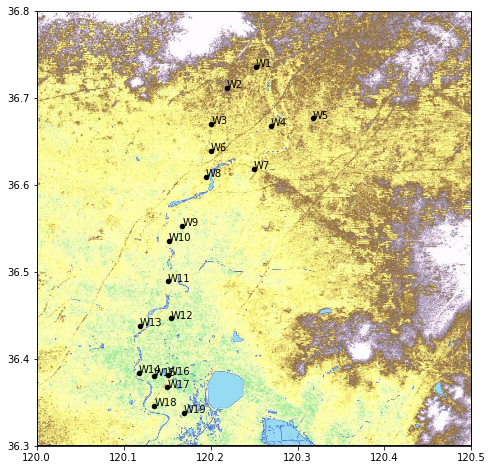

In [63]:
# File name
base_map = 'DEM.jpg'

# Parameters from DEM background
xmin, xmax, ymin, ymax = 120.0, 120.5, 36.3, 36.8

# Get well names and locations
well_names = raw_df['ShortID'].unique()
well_x = raw_df['Longitude'].unique()
well_y = raw_df['Latitude'].unique()

# Background settings
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1)
ax.set_aspect('equal') 
img = imageio.imread(base_map)
ax.imshow(img, zorder=0,  extent=[xmin, xmax, ymin, ymax])

# Plot the well locations and label them
for well, x, y in zip(well_names, well_x, well_y):
    ax.scatter(x, y, marker='o', s=20, c='k')
    ax.text(x, y, well)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
# ax.set_xlabel('Longitude', fontsize=12)
# ax.set_ylabel('Latitude', fontsize=12)
plt.show()

## Data preprocessing

In [64]:
# Parameters included for HCA including the ID
pars = ['ID', 'ShortID', 'SY', 'SM', 'TDS', 'pH', 'Ca', 'Mg', 'K', 'Na', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F']
df = raw_df[pars]

In [65]:
# Check the charge balance error (CBE)
Ca   = 40
Mg   = 24
K    = 39
Na   = 23
Cl   = 35.5
SO4  = 96
HCO3 = 61
NO3  = 62
F    = 19

df['Cations'] = df['Ca'] * 2 / Ca + df['Mg'] * 2 / Mg + df['K'] * 1 / K + df['Na'] * 1 / Na
df['Anions'] = df['Cl'] * 1 / Cl + df['SO4'] * 2 / SO4 + df['HCO3'] * 1/ HCO3 + df['NO3'] * 1 / NO3 + df['F'] * 1 / 19
df['CBE'] = abs((df['Cations'] - df['Anions']) / (df['Cations'] + df['Anions'])) * 100

print("Number of samples with CBE greater than 10% is", sum(df['CBE']>=10))
print('******************************************')
print(df.loc[df['CBE']>=10, ['ShortID', 'SY', 'SM', 'CBE']])

Number of samples with CBE greater than 10% is 8
******************************************
    ShortID    SY  SM        CBE
118     W13  2016   6  11.061959
119     W13  2016  11  38.674816
124     W12  2013   7  15.514976
176     W10  2016   6  10.633847
195      W7  2014  12  10.727036
314      W6  2016   6  10.579574
337      W4  2016   6  10.902498
346      W1  2014   8  16.228160


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [66]:
# Drop the nan and Exclude the samples with CBE>10%
tmp_df = df[(df['CBE']<=10) | (df['CBE'].isnull())][['ID', 'ShortID', 'SY', 'SM', 'pH', 'Ca', 'Mg', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F', 'TDS']].dropna(axis=0, how='any')

In [67]:
# The number of the remaining samples
print('Number of samples: ', tmp_df.shape[0])

Number of samples:  327


In [68]:
# Print the statistical information ofthe remaining samples
tmp_df[['pH', 'Ca', 'Mg', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F', 'TDS']].describe()

,pH,Ca,Mg,KNa,Cl,SO4,HCO3,NO3,F,TDS
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,7.615107,131.493639,45.826330,152.543609,182.334985,225.496789,247.520275,147.146575,0.424850,1137.870031
std,0.460667,53.841371,20.377845,162.928036,175.744758,144.944922,130.433325,139.902391,0.404052,469.483984
min,5.900000,6.680000,3.700000,10.700000,43.100000,36.700000,24.560000,0.100000,0.010000,426.000000
25%,7.300000,95.170000,32.070000,71.155000,115.130000,126.500000,154.760000,26.850000,0.200000,868.050000
50%,7.600000,127.410000,41.200000,109.000000,138.000000,177.000000,222.200000,103.720000,0.280000,1071.220000
75%,7.950000,167.480000,56.035000,173.950000,180.555000,277.370000,310.350000,226.205000,0.470000,1282.000000
max,8.900000,343.800000,140.710000,1168.720000,1658.630000,749.930000,729.220000,622.030000,2.200000,3824.020000


In [69]:
# Data transformation
X_df = np.log(tmp_df[['pH', 'Ca', 'Mg', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F']])

# Standardization 
X = X_df.values
rescaledX = StandardScaler().fit_transform(X)

In [70]:
# Print the size of final data matrix
n_samples, n_parameters = rescaledX.shape
print('Number of samples:', n_samples, '\nNumber of variables:', n_parameters)

Number of samples: 327 
Number of variables: 9


In [71]:
# Get ID and other info for the samples
Y_df = tmp_df[['ID', 'ShortID', 'SY', 'SM', 'pH', 'Ca', 'Mg', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F', 'TDS']]

## HCA one way clustering

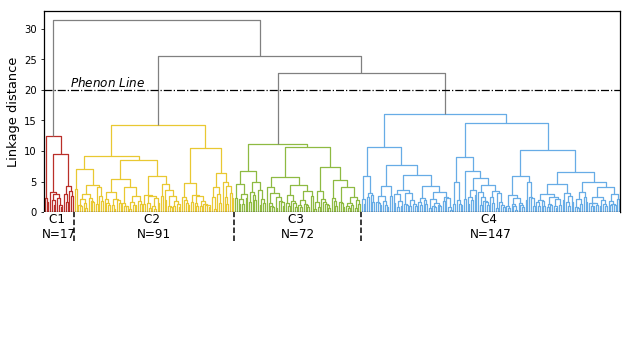

In [72]:
# Ward method
import matplotlib
# Override the default linewidth.
matplotlib.rcParams['lines.linewidth'] = 1.25

Z = hierarchy.linkage(rescaledX, method='ward', metric='euclidean')

# Set the location of phenon line
max_d = 20  

# Figure settings of the dendrogram
fig = plt.figure(figsize=(10, 8))

# Axis settings
left, bottom, width, height = 0.1, 0.35, 0.8, 0.35
ax1 = fig.add_axes([left, bottom, width, height])

# Customize the colors of the nine clusters
colors=['#BA2F29', '#E9C832', '#8EBA42', '#67ACE6']
hierarchy.set_link_color_palette(colors)

# Plot the dendrogram
hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=0, 
                     color_threshold=max_d, above_threshold_color='grey')
hierarchy.set_link_color_palette(None)
ax1.axhline(y=max_d, linestyle='-.', color='k', lw=1.25) 
ax1.set_ylabel('Linkage distance', fontsize=13)
ax1.set_yticklabels([0, 5, 10, 15, 20, 25, 30, 35], fontsize=10)
ax1.set_xticks([])
ax1.spines['top'].set_linewidth(1.25)
ax1.spines['bottom'].set_linewidth(1.25)
ax1.spines['left'].set_linewidth(1.25)
ax1.spines['right'].set_linewidth(1.25)
ax1.text(150, 20.5, '$Phenon$' + ' ' + '$Line$', fontsize=12)

# Calculate number of clusters under the linkage distance of max_d
n_clusters = np.max(np.unique(hierarchy.fcluster(Z, max_d, criterion='distance')))

# Calculate the number of samples for each cluster
cluster_size = [np.sum(hierarchy.fcluster(Z, max_d, criterion='distance')==i + 1) for i in range(n_clusters)]

# The bottom figure showing the cluster names
left, bottom, width, height = 0.1, 0.15, 0.8, 0.2
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim(0, n_samples * 10)
ax2.set_ylim(0, 2)


# Dot line to split each cluster 
cum_cluster_szie = np.cumsum(cluster_size) * 10
for i in range(n_clusters - 1):
    ax2.plot([cum_cluster_szie[i], cum_cluster_szie[i]], [1.5, 2.0], linestyle='--', color='k', lw=1.5) 

ax2.set_xticks([])
ax2.set_yticks([])
    
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')

ax2.text(0                   + (cum_cluster_szie[0] -                   0) / 2, 1.5, 'C1 \nN=%d' %cluster_size[0], ha='center', va='bottom', fontsize=12)
ax2.text(cum_cluster_szie[0] + (cum_cluster_szie[1] - cum_cluster_szie[0]) / 2, 1.5, 'C2 \nN=%d' %cluster_size[1], ha='center', va='bottom', fontsize=12)
ax2.text(cum_cluster_szie[1] + (cum_cluster_szie[2] - cum_cluster_szie[1]) / 2, 1.5, 'C3 \nN=%d' %cluster_size[2], ha='center', va='bottom', fontsize=12)
ax2.text(cum_cluster_szie[2] + (cum_cluster_szie[3] - cum_cluster_szie[2]) / 2, 1.5, 'C4 \nN=%d' %cluster_size[3], ha='center', va='bottom', fontsize=12)

plt.show()

In [73]:
# Save the clustering results
Y_df['SCI'] = hierarchy.fcluster(Z, max_d, criterion='distance')
cluster_ids = Y_df['SCI'].values
print('Number of clusters:', n_clusters)
print('Samples in each cluster:', cluster_size)

Number of clusters: 4
Samples in each cluster: [17, 91, 72, 147]


In [74]:
# Load the mean concentrations for each cluster
obs = loadtxt(prefix + 'cluster_mean.txt', delimiter='\t', comments='#') 

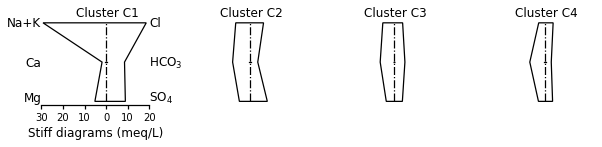

In [75]:
# Figure settings of Stiff Diagram
fig = plt.figure(figsize=(10, 8))

# Column Index for parameters
Cl   = 1
HCO3 = Cl + 1
SO4  = Cl + 2
NaK  = Cl + 3
Ca   = Cl + 4
Mg   = Cl + 5

sID = 0
xtickpositions = [-30, -20, -10.,0.,10.,20.] # desired xtickpositions for graphs
x = [-obs[sID, NaK], -obs[sID, Ca], -obs[sID, Mg], obs[sID, SO4], obs[sID ,HCO3], obs[sID, Cl], -obs[sID, NaK]]
y = [3,2,1,1,2,3,3]

# Figure size
left, bottom, width, height = 0.10, 0.13, 0.15, 0.15

ax3 = fig.add_axes([left, bottom, width, height])
ax3.fill(x, y, facecolor='w',edgecolor='k', linewidth=1.25)
ax3.plot([0,0], [1,3],'k-.', linewidth=1.25)
ax3.plot([-0.5,0.5],[2,2],'k')
ax3.set_xlim([-30, 10])
text(-30,2.9,'Na+K', fontsize=12, ha= 'right')
text(-30,1.9,'Ca',fontsize=12, ha= 'right')
text(-30,1.0,'Mg',fontsize=12, ha= 'right')
text(20,2.9,'Cl',fontsize=12, ha= 'left')
text(20,1.9,'HCO'+'$_{3}$',fontsize=12,ha= 'left')
text(20,1.0,'SO'+'$_{4}$',fontsize=12,ha= 'left')
xticks(xtickpositions, ['30', '20', '10','0','10','20'])  
ax3.spines['left'].set_color('None')
ax3.spines['right'].set_color('None')
ax3.spines['top'].set_color('None')
minorticks_off()
tick_params(which='major', direction='out', length=4, width=1.25)
tick_params(which='minor', direction='in', length=2, width=1.25)
ax3.spines['bottom'].set_linewidth(1.25)
ax3.spines['bottom'].set_color('k')
#ylim(0.8, 3.2)
setp(gca(), yticks=[], yticklabels=[])
labels = ax3.get_xticklabels()
[label.set_fontsize(10) for label in labels]
ax3.set_xlabel('Stiff diagrams (meq/L)', fontsize=12)
ax3.text(0.4, 3.25, 'Cluster C1', ha='center', va='center', fontsize=12)

sID=1
x=[-obs[sID, NaK], -obs[sID, Ca], -obs[sID, Mg], obs[sID, SO4], obs[sID ,HCO3], obs[sID, Cl], -obs[sID, NaK]]
y=[3,2,1,1,2,3,3]
left, bottom, width, height = 0.30, 0.13, 0.15, 0.15
ax4 = fig.add_axes([left, bottom, width, height])
ax4.fill(x, y, facecolor='w',edgecolor='k', linewidth=1.25)
ax4.plot([0,0], [1,3],'k-.', linewidth=1.25)
ax4.plot([-0.5,0.5],[2,2],'k')
ax4.axis('off')
#ylim(0.8, 3.2)
xlim(-30, 20)
ax4.text(0.4, 3.25, 'Cluster C2', ha='center', va='center', fontsize=12)

sID=2
x=[-obs[sID, NaK], -obs[sID, Ca], -obs[sID, Mg], obs[sID, SO4], obs[sID ,HCO3], obs[sID, Cl], -obs[sID, NaK]]
y=[3,2,1,1,2,3,3]
left, bottom, width, height = 0.50, 0.13, 0.15, 0.15
ax5 = fig.add_axes([left, bottom, width, height])
ax5.fill(x, y, facecolor='w',edgecolor='k', linewidth=1.25)
ax5.plot([0,0], [1,3],'k-.', linewidth=1.25)
ax5.plot([-0.5,0.5],[2,2],'k-.')
ax5.axis('off')
#ylim(0.8, 3.2)
xlim(-30, 20)
ax5.text(0.4, 3.25, 'Cluster C3', ha='center', va='center', fontsize=12)

sID=3
x=[-obs[sID, NaK], -obs[sID, Ca], -obs[sID, Mg], obs[sID, SO4], obs[sID ,HCO3], obs[sID, Cl], -obs[sID, NaK]]
y=[3,2,1,1,2,3,3]
left, bottom, width, height = 0.71, 0.13, 0.15, 0.15
ax6 = fig.add_axes([left, bottom, width, height])
ax6.fill(x, y, facecolor='w',edgecolor='k', linewidth=1.25)
ax6.plot([0,0], [1,3],'k-.', linewidth=1.25)
ax6.plot([-0.5,0.5],[2,2],'k')
ax6.axis('off')
#ylim(0.8, 3.2)
xlim(-30, 20)
ax6.text(0.4, 3.25, 'Cluster C4', ha='center', va='center', fontsize=12)

plt.show()

In [76]:
# Count the location frequency
print('Well', '\t', 'C1', '\t', 'C2', '\t', 'C3', '\t', 'C4', '\t', 'Total')
for well in ['W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8', 'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18', 'W19']:
    print(well,  '\t', 
          Y_df[(Y_df['ShortID']==well) & (Y_df['SCI']==1)].shape[0], '\t', 
          Y_df[(Y_df['ShortID']==well) & (Y_df['SCI']==2)].shape[0], '\t', 
          Y_df[(Y_df['ShortID']==well) & (Y_df['SCI']==3)].shape[0], '\t', 
          Y_df[(Y_df['ShortID']==well) & (Y_df['SCI']==4)].shape[0], '\t', 
          Y_df[Y_df['ShortID']==well].shape[0])


Well 	 C1 	 C2 	 C3 	 C4 	 Total
W1 	 0 	 4 	 0 	 6 	 10
W2 	 0 	 6 	 5 	 11 	 22
W3 	 0 	 2 	 4 	 15 	 21
W4 	 0 	 2 	 5 	 12 	 19
W5 	 0 	 9 	 4 	 9 	 22
W6 	 0 	 12 	 1 	 5 	 18
W7 	 0 	 1 	 3 	 14 	 18
W8 	 0 	 1 	 5 	 14 	 20
W9 	 0 	 1 	 3 	 18 	 22
W10 	 0 	 3 	 5 	 9 	 17
W11 	 0 	 1 	 7 	 12 	 20
W12 	 0 	 4 	 0 	 7 	 11
W13 	 0 	 0 	 14 	 4 	 18
W14 	 0 	 9 	 9 	 2 	 20
W15 	 1 	 14 	 3 	 4 	 22
W16 	 0 	 11 	 0 	 2 	 13
W17 	 7 	 1 	 4 	 0 	 12
W18 	 1 	 8 	 0 	 3 	 12
W19 	 8 	 2 	 0 	 0 	 10


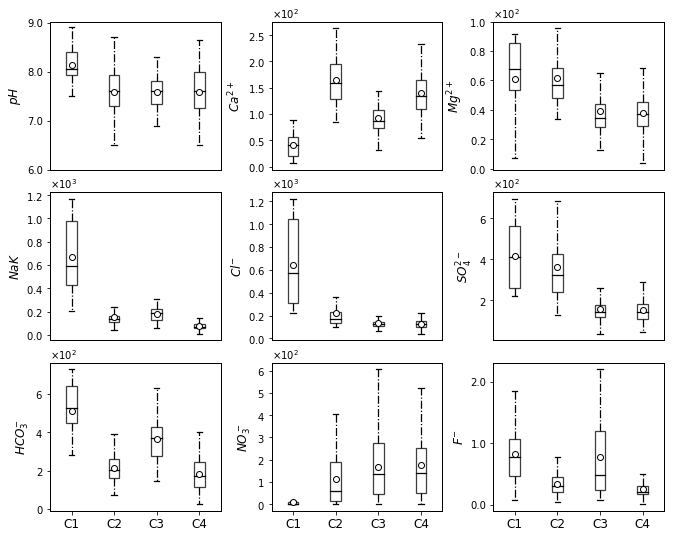

In [77]:
# Style settings for the props. of the boxplot
medianprops = dict(linestyle='-', linewidth=1.25, color='k')
meanpointprops = dict(marker='o', markeredgecolor='black',
                      markerfacecolor='white')
capprops =  dict(linestyle='-', linewidth=1.25, color='k')
whiskerprops =  dict(linestyle='-.', linewidth=1.25, color='k')

i = 1
plt.figure(figsize=(11,9))
for hydropar in ['pH', 'Ca', 'Mg', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F']:
    ax=plt.subplot(3,3,i)
    ax.spines['top'].set_linewidth(1)
    ax.spines['top'].set_color('k')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_linewidth(1)
    ax.spines['right'].set_color('k')
    
    ax = plt.gca()  
    xfmt = ScalarFormatter(useMathText=True)
    xfmt.set_powerlimits((0, 0))  # Or whatever your limits are . . .
    gca().yaxis.set_major_formatter(xfmt)

    df_par=pd.DataFrame({'C1': Y_df[Y_df['SCI']==1][hydropar],
                         'C2': Y_df[Y_df['SCI']==2][hydropar],
                         'C3': Y_df[Y_df['SCI']==3][hydropar],
                         'C4': Y_df[Y_df['SCI']==4][hydropar],}) 
    my_pal = {1: "#BA2F29", 2: "#E9C832", 3:"#89C667", 4:"#67ACE6"}
    colors = ['#BA2F29', '#E9C832', '#89C667', '#67ACE6']

    # sns.violinplot(x='SCI', y=hydropar, data=Y_df[['SCI', hydropar]], palette=my_pal)
    sns.boxplot(data = df_par, width=0.25,
                capprops=capprops,
                boxprops=dict(facecolor='white'), medianprops=medianprops,
                whiskerprops=whiskerprops,
                meanprops=meanpointprops,
                meanline=False, showmeans=True,showfliers=False)

    plt.grid(False)
    
    if i in [1, 2, 3, 4, 5, 6]:
        plt.xticks([])
    else:
        plt.xticks([0, 1, 2, 3], ['C1', 'C2', 'C3', 'C4'], fontsize=12)
        
        
    if i == 1:
        plt.ylabel('$pH$', fontsize=12)
        plt.yticks([6, 7, 8, 9], ['6.0', '7.0', '8.0', '9.0'])
    elif i == 2:
        plt.ylabel('$Ca^{2+}$', fontsize=12)
    elif i == 3:
        plt.ylabel('$Mg^{2+}$', fontsize=12)  
    elif i == 4:
        plt.ylabel('$NaK$', fontsize=12)
    elif i == 5:
        plt.ylabel('$Cl^{-}$', fontsize=12)
    elif i == 6:
        plt.ylabel('$SO_4^{2-}$', fontsize=12)  
    elif i == 7:
        plt.ylabel('$HCO_3^{-}$', fontsize=12)
    elif i == 8:
        plt.ylabel('$NO_3^-$', fontsize=12)
    elif i == 9:
        plt.ylabel('$F^{-}$', fontsize=12)
        plt.yticks([0, 1, 2], ['0.0', '1.0', '2.0'])
    elif i == 10:
        plt.ylabel('$TDS$', fontsize=12)
        
    plt.xlabel('')
    
    i=i+1
    
plt.subplots_adjust(wspace=0.3, hspace=0.15)
    
plt.show()

## PCA visualization of the HCA four clusters

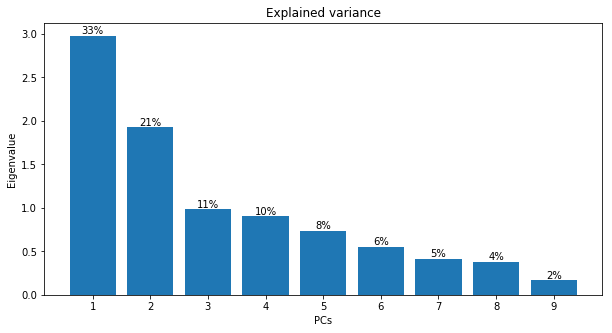

In [78]:
# Perform PCA analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=n_parameters, svd_solver='full').fit(rescaledX)
X_pca = pca.fit_transform(rescaledX)

# Plot the explained variance
plt.figure(figsize=(10, 5))
plt.bar([str(i) for i in range(1, 10)], pca.explained_variance_)
# plt.axhline(y=1, color='grey', linestyle='-.')
plt.xlabel('PCs')
plt.ylabel('Eigenvalue')
plt.title('Explained variance')

# Attach explained variance ratio above each bar
for i in range(n_parameters):
    height = pca.explained_variance_[i]
    plt.annotate('{:.0f}%'.format(pca.explained_variance_ratio_[i] * 100),
                 xy=(i, height),
                 xytext=(0, 0),  
                 textcoords="offset points",
                 ha='center', va='bottom', 
                 rotation=0, fontsize=10)

plt.show()

In [79]:
from mpl_toolkits.axes_grid1.colorbar import colorbar

def biplot1(score, coeff, y, pars, df):
    
    '''
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
       pars: the variable list
    '''
    
    xs = score[:,0]                  # projection on PC1
    ys = score[:,1]                  # projection on PC2
    n = coeff.shape[0]               # number of variables
    
    fig = plt.figure(figsize=(11, 5))
    classes = np.unique(y)
    colors=['#BA2F29', '#E9C832', '#8EBA42', '#67ACE6']
    markers=['o','o','o', 'o']
    
    plt.subplot(121)
    ax = plt.gca()
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], 
                  color = 'k', alpha = 0.8, linestyle = '-', linewidth = 1.0, overhang=0.2, head_width=0.025)
        if pars[i]=='HCO3':
            plt.text(coeff[i,0]* 1.2, coeff[i,1] * 1.2, 'HCO' + '$_3$', color = 'k', ha = 'center', va = 'center',fontsize=10)
        elif pars[i]=='SO4':
            plt.text(coeff[i,0]* 1.2, coeff[i,1] * 1.2, 'SO' + '$_4$', color = 'k', ha = 'center', va = 'center',fontsize=10)
        elif pars[i]=='NO3':
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1.2, 'NO' + '$_3$', color = 'k', ha = 'right', va = 'center',fontsize=10)
        elif pars[i]=='pH':
            plt.text(coeff[i,0]* 1.3, coeff[i,1] * 1.3, 'pH', color = 'k', ha = 'right', va = 'center',fontsize=10)
            
        else:
            plt.text(coeff[i,0]* 1.2, coeff[i,1] * 1.2, pars[i], color = 'k', ha = 'center', va = 'center',fontsize=10)

    circle = plt.Circle((0.0, 0.0), 0.75, color='k', fill=False, alpha=0.75)
    
    ax.set_aspect('equal')
    
    ax.spines['top'].set_linewidth(1.25)
    ax.spines['top'].set_color('k')
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_linewidth(1.25)
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_linewidth(1.25)
        
    plt.xlabel("PC1 loadings (33%)", size=12)
    plt.ylabel("PC2 loadings (21%)", size=12)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    plt.yticks([-1, -0.5, 0, 0.5, 1])
    plt.tick_params(axis='both', which='both', labelsize=10)
    plt.axhline(y=0, linestyle=':', linewidth=1, color='k')
    plt.axvline(x=0, linestyle=':', linewidth=1, color='k')    
        
    plt.subplot(122)
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], facecolor=colors[s], edgecolor='k', s=30, label='C'+str(l)) # color based on group
    
    plt.axhline(y=0, linestyle=':', linewidth=1, color='k')
    plt.axvline(x=0, linestyle=':', linewidth=1, color='k')    

    ax = plt.gca()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

    ax.spines['top'].set_linewidth(1.25)
    ax.spines['top'].set_color('k')
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_linewidth(1.25)
    ax.spines['left'].set_color('k')
    ax.spines['right'].set_linewidth(1.25)
    

    plt.xlabel("PC1 scores", size=12)
    plt.ylabel("PC2 scores", size=12)
    plt.xlim([-7,7])
    plt.ylim([-7,7])
    plt.xticks([-6, -3, 0, 3, 6])
    plt.yticks([-6, -3, 0, 3, 6])
    
    plt.legend(loc='lower left', frameon=False)

    plt.tick_params(axis='both', which='both', labelsize=10)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.05, hspace=0.05)
    
    return

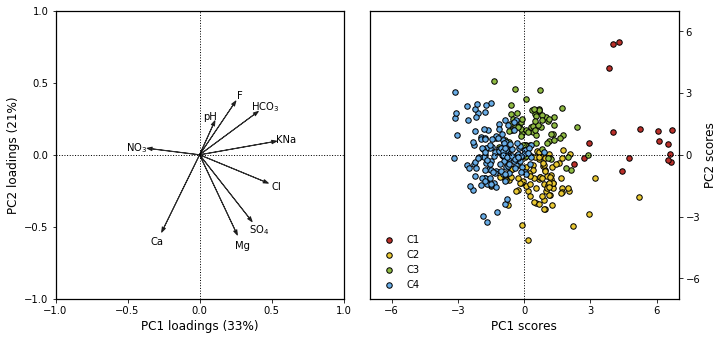

In [80]:
biplot1(X_pca[:, :2], np.transpose(pca.components_)[:, :2], cluster_ids, 
        ['pH', 'Ca', 'Mg', 'KNa', 'Cl', 'SO4', 'HCO3', 'NO3', 'F'], 
        X_df)

## t-SNE visualization of the four clusters

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 327 / 327
[t-SNE] Mean sigma: 0.976097
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.832837
[t-SNE] KL divergence after 2000 iterations: 0.893172
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 327 / 327
[t-SNE] Mean sigma: 1.035731
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.925607
[t-SNE] KL divergence after 2000 iterations: 0.801425


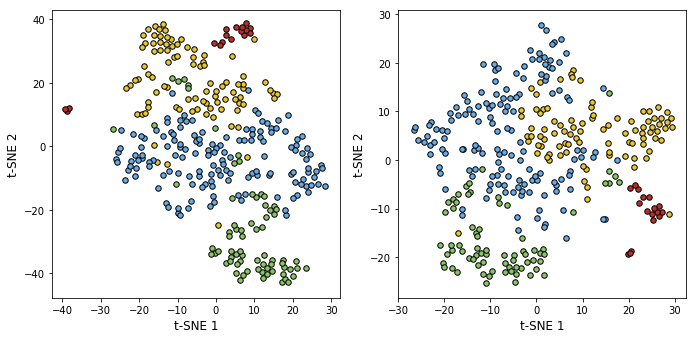

In [81]:
colors = ['#BA2F29', '#E9C832', '#89C667', '#67ACE6']
plt.figure(figsize=(11, 5))
i = 1
for perp in [20, 25]:   
    
    tsne = TSNE(n_components=2,
                init='pca',
                random_state=0, 
                perplexity=perp,
                early_exaggeration=12,
                metric='euclidean',
                method='exact',
                n_iter=2000,
                verbose=1)

    X_tsne = tsne.fit_transform(rescaledX)

    # Using clustering lables
    plt.subplot(1, 2, i)
    ax = plt.gca()
    plt.scatter(X_tsne[cluster_ids[:, ]==1, 0], X_tsne[cluster_ids[:, ]==1, 1], facecolor=colors[0], label='C1', edgecolor='k', s=30)
    plt.scatter(X_tsne[cluster_ids[:, ]==2, 0], X_tsne[cluster_ids[:, ]==2, 1], facecolor=colors[1], label='C2', edgecolor='k', s=30)
    plt.scatter(X_tsne[cluster_ids[:, ]==3, 0], X_tsne[cluster_ids[:, ]==3, 1], facecolor=colors[2], label='C3', edgecolor='k', s=30)
    plt.scatter(X_tsne[cluster_ids[:, ]==4, 0], X_tsne[cluster_ids[:, ]==4, 1], facecolor=colors[3], label='C4', edgecolor='k', s=30)

    plt.xlabel("t-SNE 1", size=12)
    plt.ylabel("t-SNE 2", size=12)
    plt.tick_params(axis='both', which='both', labelsize=10)
    
    i = i + 1
    
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.05)


## BBCA_I co-clustering 

In [82]:
df = pd.read_csv(prefix + 'coClusterMatrix.csv').replace('n.d.', 0.0075)

# Feature selection
pars = ['pH', 'Ca', 'Mg', 'KNa', 'Cl', 'SO4', 'HCO3', 'NO3', 'F']
X_df = df[pars]

# Substitution of censored values
X_df = X_df.replace('n.d.', 0.0075)

# Screening the non-measurement values
X_df = X_df.replace(-9999, np.nan)
X_df = X_df.dropna(axis=0, how='any')

# Data transformation
X = np.log(np.float64(X_df.values))

# Standardization 
rescaledX = StandardScaler().fit_transform(X)


Number of samples: 299 
Number of variables: 9


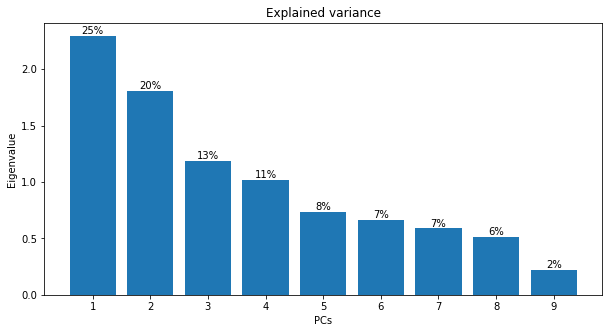

In [83]:
# Print the remianing number of samples 
n_samples, n_parameters = rescaledX.shape
print('Number of samples:', n_samples, '\nNumber of variables:', n_parameters)

# Perform PCA analysis
pca = PCA(n_components=n_parameters).fit(rescaledX)

# Plot the explained variance
plt.figure(figsize=(10, 5))
plt.bar([str(i) for i in range(1, n_parameters + 1)], pca.explained_variance_)
# plt.axhline(y=1, color='grey', linestyle='-.')
plt.xlabel('PCs')
plt.ylabel('Eigenvalue')
plt.title('Explained variance')

# Attach explained variance ratio above each bar
for i in range(n_parameters):
    height = pca.explained_variance_[i]
    plt.annotate('{:.0f}%'.format(pca.explained_variance_ratio_[i] * 100),
                 xy=(i, height),
                 xytext=(0, 0),  
                 textcoords="offset points",
                 ha='center', va='bottom', 
                 rotation=0, fontsize=10)
    
plt.show()

In [84]:
np.random.seed(10^20)

# Obtain PC1 scores from SPSS
Y = np.loadtxt(prefix + 'PC1_scoress_SPSS.txt')
outputY = Y.reshape(13, 23)
# np.savetxt('PC1_reshaped.csv', outputY , delimiter=',')

# Co-clustering using PC1 scores
rescaledY = (Y - Y.min(axis=0)) / (Y.max(axis=0) - Y.min(axis=0)) * 10 +  1e-8
inputZ = rescaledY.reshape(13, 23)

cc = Coclustering(inputZ,
                  nclusters_row=3,       # number of station clusters
                  nclusters_col=3,       # number of timestamp clusters
                  max_iterations=3000,   # maximum number of iterations
                  conv_threshold=1.e-6,  # error convergence threshold
                  nruns=5000,            # number of differently-initialized runs
                  epsilon=1.e-8          # numerical parameter
                  )

cc.run_with_threads(nthreads=4)

In [85]:
# Print station cluster and timestamp cluster indices
row_clusters = cc.results.row_clusters
col_clusters = cc.results.col_clusters
print(row_clusters)
print(col_clusters)

[0 2 1 1 0 1 0 1 1 1 0 1 0]
[0 0 0 0 0 0 0 2 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2]


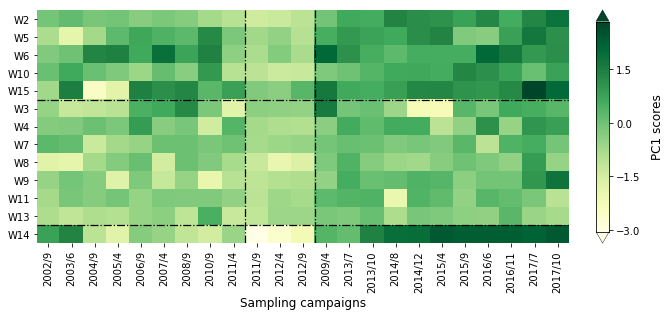

In [86]:
# Read the reshaped PC1 scores
df_D = pd.read_csv(prefix + 'PC1_scores_reshaped.csv', index_col=0)

# Axis settings
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
fig = plt.figure(figsize=(10, 10.8))

left, bottom, width, height = 0.105, 0.167, 0.795, 0.3
ax3 = fig.add_axes([left, bottom, width, height])

cf1 = sns.heatmap(df_D, cmap="YlGn", cbar=False)#, cbar_kws={'label': 'Pairwise distance', 'orientation': 'horizontal'})

ax = plt.gca()
ax.set_ylabel('')

ax.set_xlabel('Sampling campaigns', fontsize=12)

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes('right', size = '2.5%', pad = '5%')
cb1 = colorbar(ax.get_children()[0], cax = cax, orientation = 'vertical',  extend="both")
cb1.ax.set_ylabel("PC1 scores", rotation=90, labelpad=10, fontsize=12)

ax.axhline(y=5, color='k', linestyle='-.')
ax.axhline(y=12, color='k', linestyle='-.')
ax.axvline(x=9, color='k', linestyle='-.')
ax.axvline(x=12, color='k', linestyle='-.')

plt.show()